In this notebook, we would like to introduce several basic, yet important features that allows manipulations of the database using DataJoint - create tables, flexible queries and fetching data.

As always, start by import `datajoint` library.

In [13]:
import datajoint as dj

# Create Tables

Before creating the tables, we would first need to create a schema that would serve as the home of your tables. A schema is like a folder of tables, gathering a group of tables that are intuitively related. As defined by the previlledge, you can only create a schema with a name that starts with your username.  
Be sure to replace `'YOUR_USERNAME'` with your Database username (e.g. if your user name is `john`, make it `john_calcium`)

In [2]:
schema = dj.schema('shan_calcium')

Connecting shan@workshop-db.datajoint.io:3306


We now create a table for Mouse.

In DataJoint, you define each table as a class, and provide the table definition (e.g. attribute definitions) as the `definition` static string property. The class will inherit from the `dj.Manual` class provided by DataJoint (more on this later).

In [14]:
@schema
class Mouse(dj.Manual):
    definition = """
    # Experimental animals
    mouse_id             : int                          # Unique animal ID
    ---
    dob=null             : date                         # date of birth
    sex="unknown"        : enum('M','F','unknown')      # sex
    mouse_notes=""       : varchar(4096)                # other comments and distinguishing features
    """

The `---` separates the primary key attribute(s) (above) and secondary attributes (below). The primary key attributes uniquely identify an entry in a table, in this case, the `mouse_id`. The secondary attributes are other facts about the entries in this table. The `=` after the name of the field is the default value of the field. The data format is defined after the `:`, which covers the major data types that were supported by MySQL. 

The table was created the first time we declared the table.

Let's take a look at our brand new table

In [33]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features


Now we insert a few mice into the newly defined table. You can either insert 1 at a time as a dictionary using a method called `insert1` of the `dj.Manual` class

In [34]:
Mouse.insert1(
{'dob': '2019-01-05',
 'mouse_id': 0,
 'mouse_notes': '',
 'sex': 'M'})
Mouse.insert1({'dob': '2020-01-06',
 'mouse_id': 1,
 'mouse_notes': '',
 'sex': 'M'})

or many together in a batch as a list of dictionaries using `insert()`

In [35]:
Mouse.insert([
    {'dob': "2019-08-23", 'mouse_id': 2, 'sex': 'M'},
    {'dob': "2020-01-22", 'mouse_id': 3, 'sex': 'F'}])

## Data integrity

DataJoint checks for data integrity, and ensures that you don't insert a duplicate by mistake. Let's try inserting another mouse with `mouse_id: 0` and see what happens!

In [37]:
Mouse.insert1({'dob': "2019-08-25", 'mouse_id': 0, 'sex': 'F'})

DuplicateError: ("Duplicate entry '0' for key 'PRIMARY'", 'To ignore duplicate entries in insert, set skip_duplicates=True')

We now define the second table for scan sessions that is dependent on the `Mouse` table.

In [42]:
@schema
class Session(dj.Manual):
    definition = """
    -> Mouse
    session_number       : smallint                     # session number
    ---
    session_date         : date                         # date
    person               : varchar(100)                 # researcher name
    data_path            : varchar(255)                 # 
    """

Simiar as the `Mouse` table, the primary key attributes are above the `---`. Here the `->` means that the current table inherits all the primary key attributes of the Mouse table, `mouse_id`, as a part of its own primary key. Other than the `mouse_id`, a session also needs an additional `session_number` to identify itself from other sessions of the same mouse. This is an typical example of 'one-to-many' dependency.

We can look at tables and their relationships by displaying the entitiy relationship diagram (ERD).

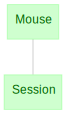

In [43]:
dj.ERD(schema)

Let's try inserting a few sessions manually.

In [44]:
Session.insert1(
    {'mouse_id': 0, 
     'session_number': 1, 
     'session_date': "2019-12-03",
     'person': 'Shan', 
     'scan_path': '/data'
    })

Session.insert1(
    {   'mouse_id': 1,
        'person': 'Thinh',
        'scan_path': '/data',
        'session_number': 1,
        'session_date': "2020-03-02"})

# Flexible Queries

DataJoint provides useful queries that allows researchers to explore their data. The three import types of queries are restrictions, projections and aggregations.

Let's first query all mice

In [47]:
Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
0,2019-01-05,M,
1,2020-01-06,M,
2,2019-08-23,M,
3,2020-01-22,F,


Note that this is a overview of the Mouse, no data have been transferred to the local machine.

## Restrictions: & 

One of the most important queries in the restriction, which allows the user to filter out their data with some conditions.

The restriction takes a few formats as the filtering condition.

In [51]:
# restrict by a string
Mouse & 'mouse_id=2'

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
2,2019-08-23,M,


In [52]:
# restrict by a dictionary
Mouse & {'mouse_id': 2}

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
2,2019-08-23,M,


There approaches for the `OR` logic:

In [53]:
# restrict as a list of dictionaries
Mouse & [{'mouse_id': 0}, {'sex': 'F'}]

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
0,2019-01-05,M,
3,2020-01-22,F,


In [56]:
# restrict with a string with the key word "or"
Mouse & 'mouse_id=0 or sex="F"'

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
0,2019-01-05,M,
3,2020-01-22,F,


In [57]:
# key word "in"
Mouse & 'mouse_id in (1, 2)'

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
1,2020-01-06,M,
2,2019-08-23,M,


Restrict for a range

In [58]:
# Mouse born after 2020-01-01
Mouse & 'dob > "2020-01-01"'

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
1,2020-01-06,M,
3,2020-01-22,F,


In [61]:
# Mouse born between 2019-06-01 and 2020-01-01
Mouse & 'dob between "2019-06-01" and "2020-01-01"'

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
2,2019-08-23,M,


Restrict with other tables

In [62]:
# Mouse that has an session
Mouse & Session

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
0,2019-01-05,M,
1,2020-01-06,M,


## Negative restriction  - 

Negative 

In [63]:
Mouse - Session

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
2,2019-08-23,M,
3,2020-01-22,F,


In [ ]:
(Mouse - {'mouse_id': 8623}).delete()

In [ ]:
Mouse * Session

In [ ]:
males = Mouse * Session & 'sex="M"'

In [ ]:
males.proj('person', 'scan_path')

In [ ]:
a = males.fetch()